In [569]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Ricty'

日本には少額投資非課税制度、通称「NISA」と呼ばれる制度が存在します。詳しくはググってもらうとして、通常株の利益には20%ほどの税金がかかりますが、NISAだとそれが非課税になります。

現在NISAには一般NISAとつみたてNISAの2種類があり、それぞれ運用できる年数、上限金額などが異なります。どちらを選んだほうが最終的にリターンが高いのか？というのが気になったので、今回はそれぞれ過去のデータを元にシミュレーションしました。

対象とする株式の商品はS&P 500のインデックスファンドとします。なおこの記事は過去のデータを分析したものであり、将来の運用結果などを保証するものではありません。最終的な投資判断は各自で行ってください。

# S&P 500年平均リターン

まずS&P 500の年平均リターンを出します。
データは [Yahoo! finance](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325462400&period2=1577836800&interval=1mo&filter=history&frequency=1mo) からダウンロードしたものを使います。期間は1928年から2019年までと、2000年から2019年までの20年間の2つを見てみます。

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1928-01-31,17.760000,17.760000,17.260000,17.570000,17.570000,0
2019-12-31,3143.850098,3247.929932,3070.330078,3230.780029,3230.780029,72054000000


0.07677447259284405

0.05639410820846351

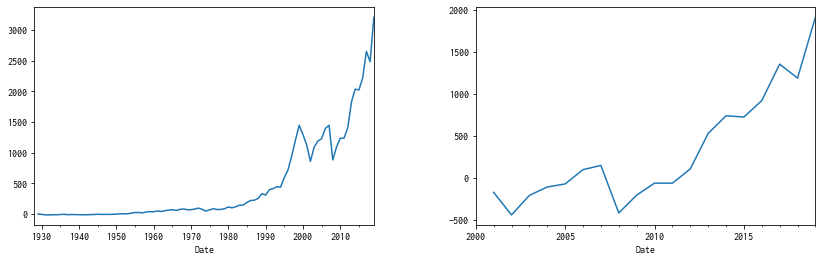

In [1072]:
def history(csvfile):
    df = pd.read_csv(csvfile, index_col='Date', parse_dates=True)
    df = df.dropna()
    df.index = df.index.to_period('M').to_timestamp('M')
    display(df.head(1).append(df.tail(1)))
    annual_price = df.resample('Y').agg({
        'Open': 'first',
        'Close': 'last',
    })
    monthly_price = df[['Open', 'Close']]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    annual_price['Close'].diff().cumsum().plot(ax=axes[0])
    annual_price.loc['2000':'2019', 'Close'].diff().cumsum().plot(ax=axes[1])
    return [
        r.pct_change(axis=1).dropna(axis=1).rename(columns={'Close': 'value'}) 
        for r in (annual_price, monthly_price)
    ]

annual_return, monthly_return = history('./^GSPC.csv')
display(annual_return['value'].mean())
display(annual_return.loc['2000':'2019', 'value'].mean())
plt.show(block=True)

1928年からのほうは約7.7%で、2000年からのほうは約5.6%ですね。直近20年を見ると、若干アンダーパフォームしているようです。

# NISA運用想定リターン

では一般NISAとつみたてNISAでS&P 500のインデックスファンドを購入し、20年間運用した場合の想定リターンを出してみます。未来のデータは持っていないので、2000年から2019年までの過去20年間のデータを元にシミュレーションします。

対象とするインデックスファンドはNISAで購入可能なもののうち、下記3つとしました。

In [1041]:
fund_df = pd.DataFrame({
    'SBIバンガードS&P500': [0.000938],
    'eMAXIS Slim米国株式(S&P500)': [0.000968],
    '農林中金<パートナーズ>つみたてNISA米国株式S&P500': [0.00495],
}, index=['信託報酬年率']).T
display(fund_df)

,信託報酬年率
SBIバンガードS&P500,0.000938
eMAXIS Slim米国株式(S&P500),0.000968
農林中金<パートナーズ>つみたてNISA米国株式S&P500,0.004950


SBIバンガードS&P500 と eMAXIS Slim米国株式(S&P500) は、NISAで購入可能なS&P 500のインデックスファンドで信託報酬が最も安い2つです。信託報酬はそれぞれ年率0.0938%と0.0968%です。
農林中金のものは一般NISAでは購入できないのですが、今回は信託報酬の違いによる差も見てみたかったので信託報酬が年率0.495%と他に比べて高い農林中金のものも対象としました。

また、前提として、一般NISAは5年で終了予定です。2019年12月、一般NISAは2028年まで延長されることが決まりましたが、今回想定している20年もの間、一般NISAが使い続けられるかはわかりませんので、あくまでそうであった場合として計算しています。

In [1042]:
def calculate(return_df, n_div=1, freq='Y'):
    base_dfs = []
    for year_limit, total_limit in (
        (1_200_000, 6_000_000),  # 一般NISA年間上限金額 / 最大金額
        (  400_000, 8_000_000),  # つみたてNISA年間上限金額 / 最大金額
    ):
        df = pd.DataFrame({
            'base': [year_limit / n_div] * len(return_df),
        }, index=return_df.index)
        df = df[df.cumsum() <= total_limit].fillna(0)
        base_dfs.append(df)
    fund_dfs = []
    for fund_name, fee in fund_df.itertuples():
        dfs = []
        for base_df in base_dfs:
            df = pd.DataFrame({'earn': 0}, index=base_df.index)
            for i, index in enumerate(df.index):
                base = base_df.loc[index, 'base']
                earn = df.loc[df.index[i - 1], 'earn']
                ret = return_df.loc[index, 'value']
                df.loc[index, 'earn'] = \
                    (base + earn) * (1 + ret) / (1 + fee / n_div)
            dfs.append(df.astype('int64'))
        df = pd.concat(dfs, keys=['一般', 'つみたて'], axis=1)
        fund_dfs.append(df)
    base_df = pd.concat(
        [df.cumsum() for df in base_dfs],
        keys=fund_dfs[0].columns.get_level_values(0),
        axis=1).astype('int64')
    df = pd.concat(
        [base_df] + fund_dfs,
        keys=['', 'SBIバンガード', 'eMAXIS', '農林中金'], 
        axis=1)
    display(df)
    plot_df = df.copy()
    plot_df.columns = df.columns.to_flat_index()
    ax = plot_df.plot(
        xticks=df.index[::n_div],
        figsize=(12, 6),
        markevery=n_div,
        style=['yo--', 'cs--'])
    ax.xaxis.set_major_formatter(FixedFormatter(df.index.year.unique()))
    plt.show(block=True)
    return df

### 年初に年間上限金額いっぱいまで買う場合

はじめに、毎年年初にNISA枠の上限金額いっぱいまで買う場合（以下、一括投資）のリターンを見てみます。

SBIバンガード              eMAXIS                農林中金          
                 一般     つみたて        一般      つみたて        一般      つみたて        一般      つみたて
               base     base      earn      earn      earn      earn      earn      earn
Date                                                                                    
2000-12-31  1200000   400000   1077319    359106   1077286    359095   1073018    357672
2001-12-31  2400000   800000   1978439    659479   1978352    659450   1966819    655606
2002-12-31  3600000  1200000   2433484    811161   2433344    811114   2414908    804969
2003-12-31  4800000  1600000   4587708   1529236   4587394   1529131   4546032   1515344
2004-12-31  6000000  2000000   6302311   2100770   6301780   2100593   6231950   2077316
2005-12-31  6000000  2400000   6485362   2573405   6484621   2573146   6387355   2539093
2006-12-31  6000000  2800000   7361726   3375200   7360665   3374804   7221530   3322932
2007-12-31  6000000  3200000   7615871   3905529   7614545   3905003   7441010   3836081
2008-12-31  6000000  3600000   4681696   2646733   4680740   2646330   4555942   2593645
2009-12-31  6000000  4000000   5775996   3758877   5774644   3758267   5598409   3678636
2010-12-31  6000000  4400000   6499710   4679971   6497994   4679145   6274721   4571352
2011-12-31  6000000  4800000   6493515   5075130   6491606   5074152   6243715   4946787
2012-12-31  6000000  5200000   7349751   6197081   7347370   6195789   7038799   6027655
2013-12-31  6000000  5600000   9516443   8541887   9513075   8539958   9077438   8289289
2014-12-31  6000000  6000000  10604836   9964568  10600765   9962120  10075239   9644423
2015-12-31  6000000  6400000  10517916  10279617  10513563  10276881   9952766   9922325
2016-12-31  6000000  6800000  11542419  11719871  11537297  11716518  10878617  11282554
2017-12-31  6000000  7200000  13693116  14378164  13686629  14373755  12854105  13804032
2018-12-31  6000000  7600000  12778641  13791226  12772204  13786698  11947772  13202517
2019-12-31  6000000  8000000  16651980  18492735  16643094  18486280  15507110  17654817

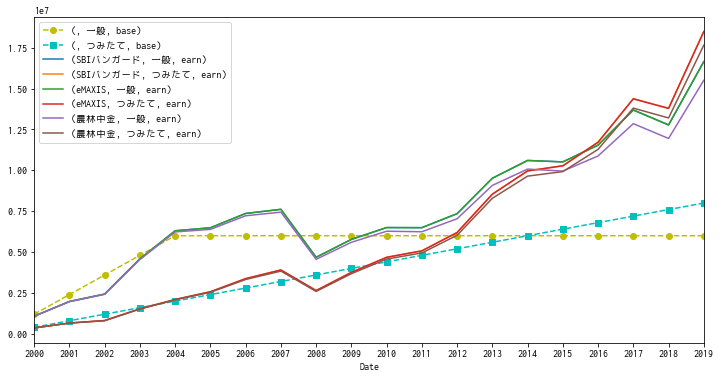

In [1068]:
annual_df = calculate(return_df=annual_return['2000':'2019'])

まず一般NISAとつみたてNISAのリターンです。パッと見ではつみたてNISAのほうが最終リターンが多いように見えますが、つみたてNISAのほうが上限金額が200万多いことによるもので、600万積み立て時点を見てみると実際には一般NISAのほうがリターンが多いのがわかります。また、つみたてNISAの積立金額が600万になったあとに上限の800万までさらに200万を積み立てるよりも、一般NISAの最終リターン + 200万のほうが大きいことが見て取れます。

In [1044]:
annual_df[annual_df[('', 'つみたて', 'base')] >= 6000000]

SBIバンガード              eMAXIS                農林中金          
                 一般     つみたて        一般      つみたて        一般      つみたて        一般      つみたて
               base     base      earn      earn      earn      earn      earn      earn
Date                                                                                    
2014-12-31  6000000  6000000  10604836   9964568  10600765   9962120  10075239   9644423
2015-12-31  6000000  6400000  10517916  10279617  10513563  10276881   9952766   9922325
2016-12-31  6000000  6800000  11542419  11719871  11537297  11716518  10878617  11282554
2017-12-31  6000000  7200000  13693116  14378164  13686629  14373755  12854105  13804032
2018-12-31  6000000  7600000  12778641  13791226  12772204  13786698  11947772  13202517
2019-12-31  6000000  8000000  16651980  18492735  16643094  18486280  15507110  17654817

SBIバンガードを例にすると、最終リターンを見ても

In [1045]:
last = annual_df.last('Y')
base, earn = last[''], last['SBIバンガード']
base.columns = earn.columns = ['一般NISA投資利益率', 'つみたてNISA投資利益率']
display(earn.T / base.T)

Date,2019-12-31
一般NISA投資利益率,2.775330
つみたてNISA投資利益率,2.311592


と、このように一般NISAのほうがROIが高いです。

次に信託報酬の違いによるリターンへの影響を見てみます。

In [1046]:
pd.concat([
    annual_df.last('Y').loc[:, pd.IndexSlice[:, c, 'earn']].diff(axis=1).fillna(0)
    for c in annual_df.columns.get_level_values(1).unique()
], axis=1)

,SBIバンガード,eMAXIS,農林中金,SBIバンガード,eMAXIS,農林中金
,一般,一般,一般,つみたて,つみたて,つみたて
,earn,earn,earn,earn,earn,earn
Date,,,,,,
2019-12-31,0.0,-8886.0,-1135984.0,0.0,-6455.0,-831463.0


一番信託報酬の低いSBIバンガードに対して、0.003%高いeMAXISは20年で6,455円から8,886円低く、約0.4%高い農林中金は831,463円から1,135,984円低いようです。信託報酬が0.4%違うと20年で80万から110万円ほどの差が出るようです。

### 年間上限金額まで毎月均等に積み立てる場合

つぎに、年間上限金額まで毎月均等に積み立てる場合（以下、積立投資）のリターンを見てみます。

SBIバンガード              eMAXIS                農林中金          
                 一般     つみたて        一般      つみたて        一般      つみたて        一般      つみたて
               base     base      earn      earn      earn      earn      earn      earn
Date                                                                                    
2000-01-31   100000    33333     94902     31634     94901     31633     94870     31623
2000-02-29   200000    66666    190968     63656    190967     63655    190873     63624
2000-03-31   300000   100000    319085    106361    319084    106361    318874    106291
2000-04-30   400000   133333    406147    135382    406145    135381    405808    135269
2000-05-31   500000   166666    495016    165005    495013    165004    494519    164839
...             ...      ...       ...       ...       ...       ...       ...       ...
2019-08-31  6000000  7866666  14003060  14995472  13995892  14990493  13076707  14347296
2019-09-30  6000000  7899999  14327971  15377517  14320601  15372383  13375652  14709383
2019-10-31  6000000  7933333  14585520  15687865  14577982  15682600  13611533  15002706
2019-11-30  6000000  7966666  15015881  16185067  15008082  16179607  14008472  15474519
2019-12-31  6000000  7999999  15429875  16665550  15421823  16659897  14389881  15930085

[240 rows x 8 columns]

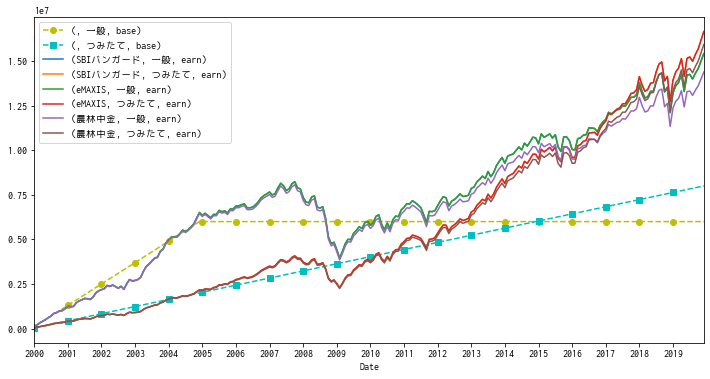

In [1047]:
monthly_df = calculate(return_df=monthly_return['2000':'2019'], n_div=12, freq='M')

In [1048]:
display(monthly_df[monthly_df[('', 'つみたて', 'base')] == 5999999])

SBIバンガード             eMAXIS               農林中金         
                 一般     つみたて        一般     つみたて        一般     つみたて        一般     つみたて
               base     base      earn     earn      earn     earn      earn     earn
Date                                                                                 
2014-12-31  6000000  5999999  10697931  9782212  10693952  9779903  10178983  9479568

一般NISAとつみたてNISAのリターンの差は一括投資と傾向は同じようです。気になる一括投資と積立投資の差を見てみます。

In [1049]:
annual_last = annual_df.last('Y')
monthly_last = monthly_df.last('M')
pd.concat([annual_last, monthly_last, annual_last - monthly_last])

SBIバンガード              eMAXIS                農林中金          
                 一般     つみたて        一般      つみたて        一般      つみたて        一般      つみたて
               base     base      earn      earn      earn      earn      earn      earn
Date                                                                                    
2019-12-31  6000000  8000000  16651980  18492735  16643094  18486280  15507110  17654817
2019-12-31  6000000  7999999  15429875  16665550  15421823  16659897  14389881  15930085
2019-12-31        0        1   1222105   1827185   1221271   1826383   1117229   1724732

一番下が一括投資とのリターンの差です。いずれも一括投資のほうがリターンが高いようです。巷でよく言われているドルコスト平均法によるメリットは、少なくともS&P 500については享受できないようです。まぁドルコスト平均法は価格が下がった場合に平均取得価額を下げることによってダメージを少なくする、あるいは全く無くするものなので、右肩上がりのS&P 500に対しては無力というのもわからなくはないです。

# まとめ

過去のデータを使ったシミュレーションでは、一般NISAを年初に上限金額まで買うのが一番リターンが良いという結果になりました。積み立てる金額によりますが、NISAの年間上限金額まで積み立てるという前提においては、つみたてNISAは一般NISAをアウトパフォームしないので、年間上限金額まで積み立てられるのであれば一般NISAのほうがよいでしょう。

また、今回シミュレーション対象に選んだS&P 500ですが、今後も同じように右肩上がりになるかどうかはわかりません。ですが少なくとも日経平均株価のインデックスファンドを買うより、よほど期待値は高いと個人的には思います。

あと、こういうのはスプレッドシート使って出したほうが早いと思いますが、今回はコードを書いて載せることによる再現性を重視しました。この記事はすべて[Jupyter Notebook](https://jupyter.org/)を使って書かれています。コードをコピペするか、https://github.com/naoina/kuune.org/blob/master/content/text/nisa/index.ipynb から持ってくれば容易に手元で再現できるので、気になる方は試してみてください。